En este laboratorio sobre una Red neuronal convolucional para la clasificación de imágenes mediante Trasnfer learning.

Estos dos escenarios principales de aprendizaje por transferencia se presentan a continuación:

## Fine tunning con ConvNeXT

En lugar de una inicialización aleatoria, inicializamos la red con una red preentrenada, como la que se entrena con el conjunto de datos imagenet 1000. El resto del entrenamiento se desarrolla de forma normal.

## ConvNet as fixed feature extractor
En este caso, congelamos los pesos de toda la red, excepto los de la capa final completamente conectada. Esta última capa completamente conectada se reemplaza por una nueva con pesos aleatorios y solo se entrena esta capa.

In [1]:
# ======================
# 🔹 PyTorch principal
# ======================
import torch                      # Librería base de PyTorch (tensores, operaciones en CPU/GPU)
import torch.nn as nn             # Construcción de redes neuronales (capas, pérdidas, activaciones)
import torch.optim as optim       # Optimizadores (SGD, Adam, RMSprop, etc.)
from torch.optim import lr_scheduler  # Planificadores de tasa de aprendizaje
import torch.backends.cudnn as cudnn  # Optimizaciones para GPU con cuDNN (NVIDIA)

# ======================
# 🔹 NumPy
# ======================
import numpy as np                # Cálculo científico y manejo de arrays

# ======================
# 🔹 TorchVision
# ======================
import torchvision                 # Librería de visión por computadora para PyTorch
from torchvision import datasets, models, transforms
# datasets  → carga datasets comunes (ImageNet, CIFAR, MNIST…)
# models    → modelos preentrenados (ResNet, ConvNeXt, EfficientNet, etc.)
# transforms → transformaciones de imágenes (resize, crop, normalización)

# ======================
# 🔹 Visualización
# ======================
import matplotlib.pyplot as plt   # Graficar curvas, imágenes y resultados

# ======================
# 🔹 Utilidades generales
# ======================
import time                       # Medir tiempos (entrenamiento, inferencia, etc.)
import os                         # Manejo de archivos y rutas
from PIL import Image             # Procesamiento de imágenes (abrir, convertir, manipular)
from tempfile import TemporaryDirectory  # Crear carpetas temporales (para datasets/resultados)

# ======================
# 🔹 Configuraciones extra
# ======================
cudnn.benchmark = True   # Acelera el entrenamiento en GPU si las entradas tienen tamaño fijo
plt.ion()               # Activa modo interactivo en matplotlib (los gráficos no bloquean el script)


## Carga de datos

Usaremos los paquetes torchvision y torch.utils.data para cargar los datos.

El problema que resolveremos es entrenar un modelo para clasificar:

- Llantas
- Baldes de plastico
- Filtros de aceite de auto
- Tapas de baldes
- Conservas de cafe

Contamos con unas 35.805 imágenes de entrenamiento para cada una de ellas. tomaremos el 20% de validacion de cada clase. No

Este conjunto de datos es un subconjunto muy pequeño de imagenet.

In [18]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = r"C:\Users\Admin\Ciencias\Residuos solidos\data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


## Visualizacion de imagenes

Visualicemos algunas imágenes de entrenamiento para comprender las ampliaciones de datos.

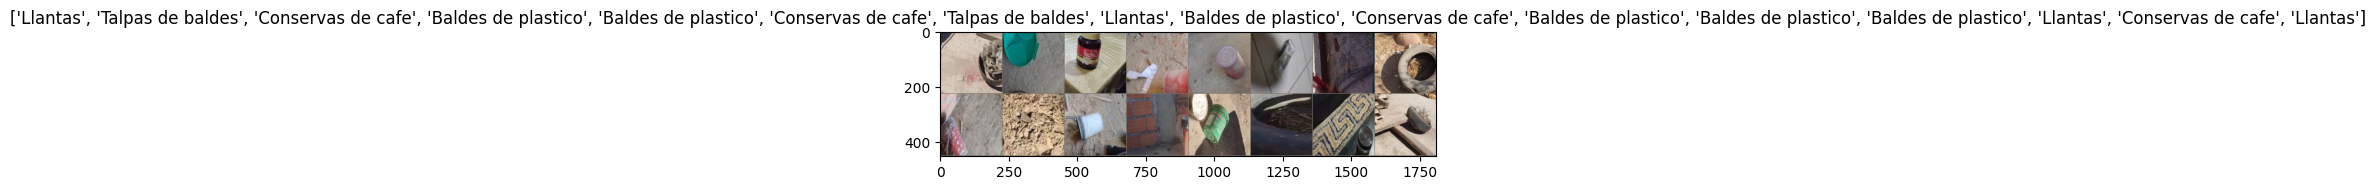

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Entrenamiento del modelo

Ahora, escribamos una función general para entrenar un modelo. A continuación, ilustraremos:

- Programación de la tasa de aprendizaje
- Guardar el mejor modelo

A continuación, el parámetro "scheduler" es un objeto "scheduler" de LR de torch.optim.lr_scheduler.

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    #Creamos un directorio temporarl para guardar puntos de guardado
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
            
            # Cada epoca tiene un entrenamiento y fase de validacion
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Ponemos el modelo a entrenar
                else:
                    model.eval()   # Ponemos el modelo a evaluar

                running_loss = 0.0
                running_corrects = 0

                # Itera sobre los datos
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # Poner cero los gradientes de los parametros
                    optimizer.zero_grad()

                    # forward
                    # track el historial si solo esta en train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize solo si esta en la fase de entrenamiento
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # estadisticas
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # Copia profunda del modelo
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # Cargar los mejores pesos del modelo
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

## Visualizando las predicciones del modelo
Funcion generica para mostrar predicciones para unas pocas imagenes


In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
import torch
import torch.nn as nn
from torchvision import models

# Limpiar caché de CUDA antes de empezar
torch.cuda.empty_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Verificar memoria disponible
if torch.cuda.is_available():
    print(f"Memoria GPU total: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
    print(f"Memoria GPU reservada: {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
    print(f"Memoria GPU asignada: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

Usando dispositivo: cuda
Memoria GPU total: 6.00 GB
Memoria GPU reservada: 0.00 GB
Memoria GPU asignada: 0.00 GB


## Finetuning the ConvNet

Cargamos un modelo previamente entrenado y restablezca la capa final completamente conectada.

Primero imprimimos las clases disponibles:

In [7]:
print(class_names)  # Muestra las 5 clases
for inputs, labels in dataloaders['train']:
    print(labels)    # Deben ser 0,1,2,3,4
    break

['Baldes de plastico', 'Conservas de cafe', 'Filtros de acite de auto', 'Llantas', 'Talpas de baldes']
tensor([3, 3, 3, 1, 0, 0, 0, 1, 1, 4, 2, 4, 0, 3, 4, 0])


In [8]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar ConvNeXt Tiny preentrenado
model_ft = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# Ajustar la capa final (classifier) al número de clases
num_ftrs = model_ft.classifier[2].in_features
model_ft.classifier[2] = nn.Linear(num_ftrs, 5)  # 5 clases

# Mover el modelo al dispositivo
model_ft = model_ft.to(device)

# Definir criterio y optimizador
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


## Entrenamiento y evaluacion

Debería tardar entre 15 y 25 minutos en la CPU. Sin embargo, en la GPU, tarda menos de un minuto.

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6345 Acc: 0.7508
val Loss: 0.1148 Acc: 0.9630

Epoch 1/24
----------
train Loss: 0.1501 Acc: 0.9479
val Loss: 0.0124 Acc: 0.9961

Epoch 2/24
----------
train Loss: 0.0849 Acc: 0.9707
val Loss: 0.0029 Acc: 0.9997

Epoch 3/24
----------
train Loss: 0.0635 Acc: 0.9784
val Loss: 0.0056 Acc: 0.9990

Epoch 4/24
----------
train Loss: 0.0513 Acc: 0.9823
val Loss: 0.0066 Acc: 0.9973

Epoch 5/24
----------
train Loss: 0.0471 Acc: 0.9835
val Loss: 0.0056 Acc: 0.9985

Epoch 6/24
----------
train Loss: 0.0401 Acc: 0.9860
val Loss: 0.0088 Acc: 0.9976

Epoch 7/24
----------
train Loss: 0.0175 Acc: 0.9939
val Loss: 0.0007 Acc: 0.9997

Epoch 8/24
----------
train Loss: 0.0147 Acc: 0.9952
val Loss: 0.0007 Acc: 0.9997

Epoch 9/24
----------
train Loss: 0.0133 Acc: 0.9951
val Loss: 0.0007 Acc: 0.9997

Epoch 10/24
----------
train Loss: 0.0118 Acc: 0.9959
val Loss: 0.0007 Acc: 0.9999

Epoch 11/24
----------
train Loss: 0.0138 Acc: 0.9952
val Loss: 0.0007 Acc: 0.9997

Ep

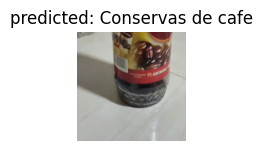

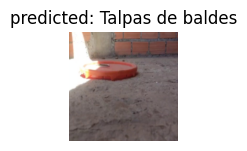

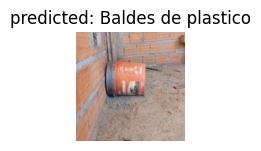

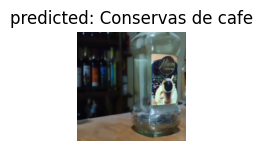

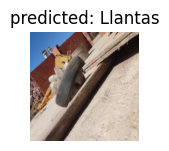

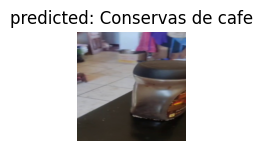

In [11]:
visualize_model(model_ft)

## ConvNet as fixed feature extractor
Aquí, necesitamos congelar toda la red excepto la capa final. Debemos configurar requires_grad = False para congelar los parámetros y evitar que los gradientes se calculen en backward().

In [16]:
all_labels = []
for _, labels in dataloaders['train']:
    all_labels.extend(labels.tolist())
print("Clases únicas:", set(all_labels))

Clases únicas: {0, 1, 2, 3, 4}


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models

# Cargar ConvNeXt preentrenado en ImageNet
model_conv = models.convnext_tiny(weights=models.ConvNeXt_Tiny_Weights.IMAGENET1K_V1)

# Congelar todas las capas
for param in model_conv.parameters():
    param.requires_grad = False

# Reemplazar la última capa (classifier) por una nueva con tus clases
num_ftrs = model_conv.classifier[2].in_features
model_conv.classifier[2] = nn.Linear(num_ftrs, 5)  # 5 clases

model_conv = model_conv.to(device)

# Definir loss
criterion = nn.CrossEntropyLoss()

# Optimizar solo los parámetros de la última capa
optimizer_conv = optim.SGD(model_conv.classifier[2].parameters(), lr=0.001, momentum=0.9)

# Scheduler (reduce LR cada 7 épocas por 0.1)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [24]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [25]:
visualize_model_predictions(
    model_ft,
    img_path=r"C:\Users\Admin\Ciencias\Residuos solidos\data\val\Filtros de acite de auto\1b02q63nr7nkjnnc.jpg"
)

plt.ioff()
plt.show()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Entrenamiento y evalucaion

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
